# Explore the Benefits of Rebalancing

In this exercise, we are going to explore the benefits of synthetic rebalancing of heavily imbalanced datasets, where a minority class of interest accounts for less than 0.1% of cases. 

Rebalancing can be useful for cases where we want to learn more of an otherwise small or underrepresented population segment by seeing more examples thereof. Of course, also a synthesizer can only leverage the data that it has seen. But if the method is data-efficient, and in particular more effective than the downstream data consumer, then it is possible to gain a significant advantage by synthetic rebalancing.

<img src='./rebalancing.png' width="600px"/>

In terms of evaluation, we again turn towards the Train-Synthetic-Test-Real approach to benchmark the predictive accuracy of a model that is trained on the (rebalanced) synthetic data, and compare that to a model trained on the (imbalanced) actual data. In addition, we will also benchmark against established methods for rebalancing, like naive upsampling as well as SMOTE. All four models are then evaluated on a holdout data, and compared in terms of predictive performance.

## Synthesize Data via MOSTLY AI

For this tutorial, we will be using again the UCI Adult Income [[1](#refs)] dataset, as well as the same training and validation split, that was used in the Train-Synthetic-Test-Real tutorial. However, we did create an artificial imbalance of 0.1% of low-income records in the training data, by downsampling the minority class. The corresponding preparation script can be found at the end of this notebook.

1. Download `census-training-imbalanced.csv` by clicking [here](https://github.com/mostly-ai/mostly-tutorials/raw/dev/rebalancing/census-training-imbalanced.csv) and pressing Ctrl+S to save the file locally.

2. Synthesize `census-training-imbalanced.csv` via [MOSTLY AI](https://mostly.ai/), configure column `income` as `categorical`, and rebalance it by setting the probability for value `>50K` to 50%. Save the column settings, and then launch the job.

<img src='./screen1.png' width="600px"/>

3. Once the job has finished, download the generated synthetic data as CSV file to your computer.

4. Upload the generated synthetic data to this Notebook via executing the next cell.

In [1]:
# upload synthetic dataset
import pandas as pd
try:
    # check whether we are in Google colab
    from google.colab import files
    print("running in COLAB mode")
    repo = 'https://github.com/mostly-ai/mostly-tutorials/raw/dev/rebalancing'
    import io
    uploaded = files.upload()
    syn = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))
    print(f"uploaded synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")
except:
    print("running in LOCAL mode")
    repo = '.'
    print("adapt `syn_file_path` to point to your generated synthetic data file")
    syn_file_path = './census-synthetic-balanced.csv'
    syn = pd.read_csv(syn_file_path)
    print(f"read synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")
    
trn = pd.read_csv(f'{repo}/census-training-imbalanced.csv')
print(f'read training data with {trn.shape[0]:,} records and {trn.shape[1]} attributes')

running in LOCAL mode
adapt `syn_file_path` to point to your generated synthetic data file
read synthetic data with 29,753 records and 15 attributes
read training data with 29,753 records and 15 attributes


## Explore Synthetic Data

### Samples Random Records

Let's first show 10 randomly sampled original records, from the imbalanced dataset. Try executing the cell multiple times, to see different samples. Still, due to the strong imbalance, you will hardly ever encounter a sample of the high income class (i.e. `income` being `>50K`).

In [2]:
trn.sample(n=10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
13803,36,Self-emp-inc,116133,HS-grad,9,Never-married,Exec-managerial,Own-child,White,Male,0,0,41,United-States,<=50K
26665,42,?,338281,Assoc-voc,11,Married-civ-spouse,?,Wife,White,Female,0,0,20,Iran,<=50K
20457,32,Private,312403,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K
7287,19,Private,393712,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Female,0,0,20,United-States,<=50K
6173,24,Private,217226,Some-college,10,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
26739,24,Local-gov,134181,Masters,14,Never-married,Prof-specialty,Own-child,White,Female,0,0,40,United-States,<=50K
2838,18,Private,120029,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States,<=50K
2972,21,Private,321369,10th,6,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
6981,24,Private,127159,Some-college,10,Never-married,Other-service,Other-relative,White,Female,0,0,24,?,<=50K
15237,22,?,148409,Some-college,10,Never-married,?,Own-child,White,Male,0,1721,40,United-States,<=50K


Let's now display 10 randomly sampled synthetic records. Again, run the cell multiple times. This time, you should see that the records are evenly distributed across the two `income` classes.

In [3]:
syn.sample(n=10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
2063,40,Self-emp-not-inc,261058,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,3138,0,97,United-States,>50K
23399,53,Private,169005,HS-grad,9,Divorced,Adm-clerical,Not-in-family,Other,Male,0,0,40,Greece,<=50K
4304,42,Self-emp-inc,31907,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,4064,0,50,United-States,>50K
22779,22,Private,81474,Assoc-voc,11,Never-married,Sales,Own-child,Asian-Pac-Islander,Female,0,0,72,United-States,<=50K
20693,35,Private,103971,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Female,0,0,40,United-States,<=50K
12499,27,Private,196313,HS-grad,9,Married-civ-spouse,Priv-house-serv,Wife,White,Female,0,0,40,United-States,<=50K
20418,41,Self-emp-not-inc,54930,10th,6,Married-civ-spouse,Sales,Husband,White,Male,0,0,85,United-States,<=50K
29337,25,Private,217052,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,37,United-States,<=50K
4687,24,Private,188473,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,30,United-States,<=50K
22147,60,Private,276835,11th,7,Divorced,Sales,Not-in-family,Black,Male,0,1876,50,United-States,>50K


### Sample Female Doctors with a High Income

Let's now investigate all female doctors with a high income. But, it turns out there are actually none in the original data, thus we won't be able to learn anything.

In [4]:
trn[(trn['income']=='>50K') & (trn.sex=='Female') & (trn.education=='Doctorate')]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income


However, the synthetic data does contain a list of realistic, statistically sound female doctors with a high income, that allow to learn about this particular subsegment.

In [5]:
syn[(syn['income']=='>50K') & (syn.sex=='Female') & (syn.education=='Doctorate')].sample(n=10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
8845,44,Private,125825,Doctorate,16,Never-married,Prof-specialty,Unmarried,White,Female,7174,0,40,United-States,>50K
15052,40,Private,41991,Doctorate,16,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,>50K
28696,34,Private,122472,Doctorate,16,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K
22151,36,Private,54458,Doctorate,16,Divorced,Prof-specialty,Unmarried,Amer-Indian-Eskimo,Female,0,0,75,United-States,>50K
420,52,Private,298273,Doctorate,16,Divorced,Prof-specialty,Unmarried,White,Female,0,0,60,United-States,>50K
14863,37,State-gov,49379,Doctorate,16,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,99,United-States,>50K
12654,58,Private,79139,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,0,0,40,United-States,>50K
1339,43,Self-emp-not-inc,144703,Doctorate,16,Married-spouse-absent,Prof-specialty,Not-in-family,Black,Female,0,0,60,United-States,>50K
9394,50,Self-emp-not-inc,168472,Doctorate,16,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,60,United-States,>50K
8663,65,Private,309292,Doctorate,16,Widowed,Prof-specialty,Unmarried,White,Female,0,0,40,United-States,>50K


## Compare ML Performance via TSTR

In [6]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

target_col = 'income'
target_val = '>50K'

def prepare_xy(df: pd.DataFrame):
    y = (df[target_col]==target_val).astype(int)
    str_cols = [col for col in df.select_dtypes(['object', 'string']).columns if col != target_col]
    for col in str_cols:
        df[col] = pd.Categorical(df[col])
    cat_cols = [col for col in df.select_dtypes('category').columns if col != target_col]
    num_cols = [col for col in df.select_dtypes('number').columns if col != target_col]
    for col in num_cols:
        df[col] = df[col].astype('float')
    X = df[cat_cols + num_cols]
    return X, y

def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    model = lgb.train(
        params={
            'verbose': -1,
            'metric': 'auc',  
            'objective': 'binary'
        }, 
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5)],
    )
    return model

def evaluate_model(model, hol):
    X_hol, y_hol = prepare_xy(hol)
    probs = model.predict(X_hol)
    preds = (probs >= 0.5).astype(int)
    auc = roc_auc_score(y_hol, probs)
    f1 = f1_score(y_hol, probs>0.5, average='macro')
    probs_df = pd.concat([
        pd.Series(probs, name='probability').reset_index(drop=True),
        pd.Series(y_hol, name='target').reset_index(drop=True)
    ], axis=1)
    fig = sns.displot(data=probs_df, x='probability', hue='target', bins=20, palette=['#008CFB', '#FF004F'])
    fig = plt.title(f"AUC: {auc:.1%}, F1 Score: {f1:.2f}", fontsize = 20)
    plt.show()
    return auc

import warnings
warnings.filterwarnings('ignore')

In [7]:
df_hol = pd.read_csv(f'{repo}/census-holdout.csv')
df_hol_min = df_hol.loc[df_hol['income']=='>50K']
print(f"Holdout data consists of {df_hol.shape[0]:,} records",
      f"with {df_hol_min.shape[0]:,} samples from the minority class")

Holdout data consists of 9,768 records with 2,337 samples from the minority class


### Train model on the original imbalanced training data

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.320482


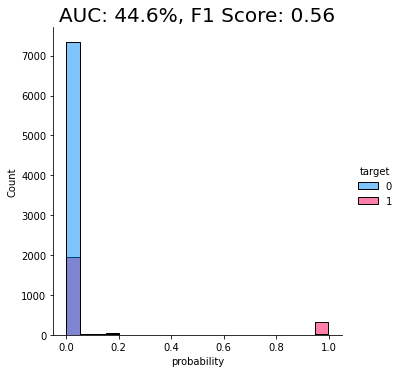

In [8]:
X_trn, y_trn = prepare_xy(trn)
model_trn = train_model(X_trn, y_trn)
auc_trn = evaluate_model(model_trn, df_hol)

With an AUC of about 50%, the model trained on the imbalanced dataset is just as good as a flip of a coin. I.e., the downstream LightGBM model is not able to learn any signal due to the low number of samples.

### Train model on naively rebalanced training data

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 1


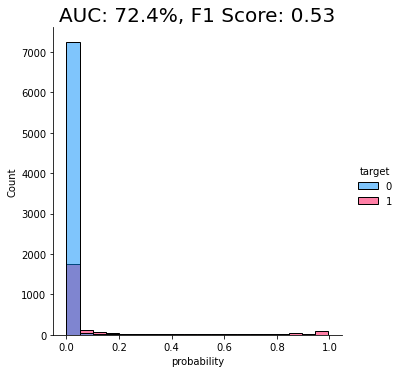

In [9]:
from imblearn.over_sampling import RandomOverSampler
X_trn, y_trn = prepare_xy(trn)
sm = RandomOverSampler(random_state=1)
X_trn_up, y_trn_up = sm.fit_resample(X_trn, y_trn)
model_trn_up = train_model(X_trn_up, y_trn_up)
auc_trn_up = evaluate_model(model_trn_up, df_hol)

Random "naive" upsampling [[2](#refs)], which simply adds minority samples multiple times to achieve a balance, only marginally helps the downstream model in this case.

### Train model on SMOTE rebalanced training data

SMOTE upsampling [[3](#refs)], which creates novel (non-privacy-preserving) samples by interpolating between neighboring samples, does boost the performance of the downstream model to close to 80%.

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.999947


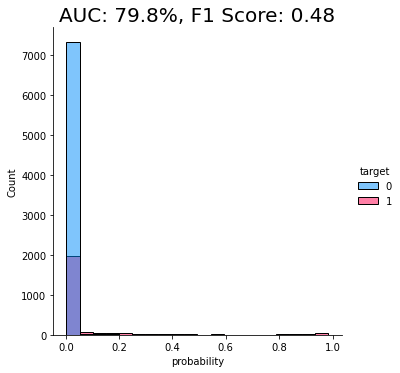

In [10]:
from imblearn.over_sampling import SMOTENC
X_trn, y_trn = prepare_xy(trn)
sm = SMOTENC(categorical_features=X_trn.dtypes=='category', random_state=1)
X_trn_smote, y_trn_smote = sm.fit_resample(X_trn, y_trn)
model_trn_smote = train_model(X_trn_smote, y_trn_smote)
auc_trn_smote = evaluate_model(model_trn_smote, df_hol)

### Train model on balanced synthetic data

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	valid_0's auc: 0.788344


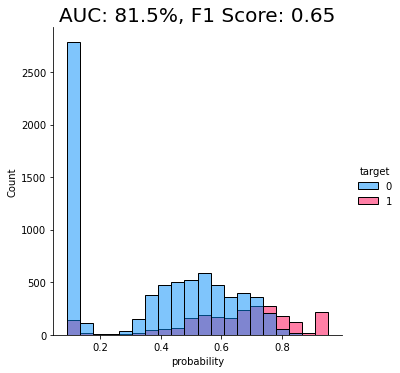

In [11]:
X_syn, y_syn = prepare_xy(syn)
model_syn = train_model(X_syn, y_syn)
auc_syn = evaluate_model(model_syn, df_hol)

Both, performance measures, the AUC [[4](#refs)] as well as the macro-averaged F1 score [[5](#refs)] are significantly better for the model that was trained on synthetic data, than if it were trained on any of the other methods. This is a strong proof of value of synthetic rebalancing for learning more about a small sub-group within the population.

## Conclusion

For the given dataset and the given synthesizer we can see, that both data analysts as well as AI engineers can learn more from a balanced synthetic dataset when compared to the imbalanced original dataset. Note, that the actual lift in performance may vary, depending on the dataset, the predictive task, and the chosen ML model.

## Further exercises

In addition to walking through the above instructions, we suggest..
* to repeat the experiments for different class imbalances - see the helper script at the bottom to create such experiments
* to repeat the experiments for different datasets, ML models, etc.

## References<a class="anchor" name="refs"></a>

1. https://archive.ics.uci.edu/ml/datasets/adult
1. https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
1. https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html
1. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
1. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

## Extras - Data Preparation

The following code snippet can be used to create an artificially imbalanced training dataset.

In [12]:
def create_imbalance(df, target, ratio):
    val_min, val_maj = df[target].value_counts().sort_values().index
    df_maj = df.loc[df[target]==val_maj]
    n_min = int(df_maj.shape[0]/(1-ratio)*ratio)
    df_min = df.loc[df[target]==val_min].sample(n=n_min, random_state=1)
    df_maj = df.loc[df[target]==val_maj]
    df_imb = pd.concat([df_min, df_maj]).sample(frac=1, random_state=1)
    return df_imb

df_trn = pd.read_csv(f'{repo}/census-training.csv')
df_trn_imb = create_imbalance(df_trn, 'income', 1/1000)
df_trn_imb.to_csv('census-training-imbalanced.csv', index=False)